In [14]:
import os

fname = os.path.join('jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


Now, convert all 420,551 lines of data into a Numpy array.

### Parse the Data

In [15]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

### Plott The Temperature Timeseries

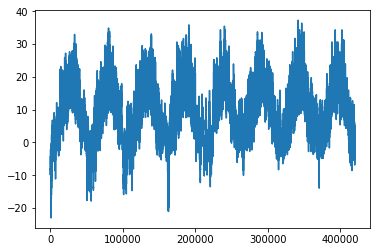

In [16]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

### Plot The First 10 Days of The Temperature Timeseries
Here is a more narrow plot of the first 10 days of temperature data. Because the data is recorded every 10 minutes, we get 144 data points per day.

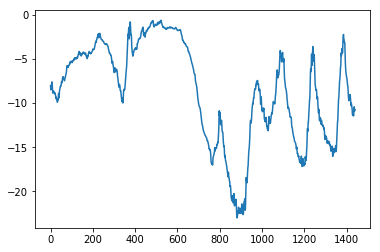

In [17]:
plt.plot(range(1440), temp[:1440])
plt.show()

In [18]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [19]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [20]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

In [21]:
# This is how many steps to draw from `val_gen` in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen` in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [68]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


In [69]:
celsius_mae = 0.29 * std[1]
celsius_mae

2.5672247338393395

In [70]:
from keras import Sequential
from keras import layers
from keras.optimizers import RMSprop

model=Sequential()
model.add(layers.Flatten(input_shape=(lookback//step, float_data.shape[-1])))
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(1))

In [71]:
model.compile(optimizer=RMSprop(), loss='mae')

In [72]:
history= model.fit_generator(train_gen, steps_per_epoch=500,
                            epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 9s 19ms/step - loss: 1.6750 - val_loss: 1.0250
Epoch 2/20
500/500 [==============================] - 9s 17ms/step - loss: 0.6666 - val_loss: 0.4713
Epoch 3/20
500/500 [==============================] - 8s 17ms/step - loss: 0.3752 - val_loss: 0.3421
Epoch 4/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2973 - val_loss: 0.3288
Epoch 5/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2708 - val_loss: 0.3075
Epoch 6/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2573 - val_loss: 0.3320
Epoch 7/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2476 - val_loss: 0.3143
Epoch 8/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2421 - val_loss: 0.3368
Epoch 9/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2354 - val_loss: 0.3419
Epoch 10/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2302 - val_lo

Let’s display the loss curves for validation and training

### Plot results

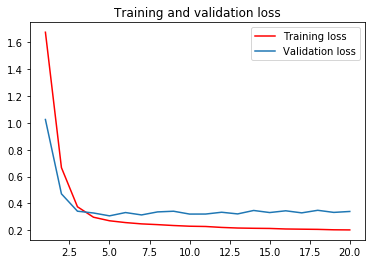

In [73]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [15]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model= Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [16]:
model.compile(optimizer=RMSprop(), loss='mae')

In [17]:
history= model.fit_generator(train_gen, steps_per_epoch=500, epochs=20,
                            validation_data= val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 156s 312ms/step - loss: 0.3026 - val_loss: 0.2727
Epoch 2/20
500/500 [==============================] - 156s 313ms/step - loss: 0.2842 - val_loss: 0.2704
Epoch 3/20
500/500 [==============================] - 156s 313ms/step - loss: 0.2742 - val_loss: 0.2653
Epoch 4/20
500/500 [==============================] - 154s 309ms/step - loss: 0.2718 - val_loss: 0.2673
Epoch 5/20
500/500 [==============================] - 155s 310ms/step - loss: 0.2653 - val_loss: 0.2700
Epoch 6/20
500/500 [==============================] - 154s 308ms/step - loss: 0.2629 - val_loss: 0.2655
Epoch 7/20
500/500 [==============================] - 147s 294ms/step - loss: 0.2577 - val_loss: 0.2682
Epoch 8/20
500/500 [==============================] - 142s 283ms/step - loss: 0.2543 - val_loss: 0.2661
Epoch 9/20
500/500 [==============================] - 141s 282ms/step - loss: 0.2509 - val_loss: 0.2649
Epoch 10/20
500/500 [==============================] - 141s 282m

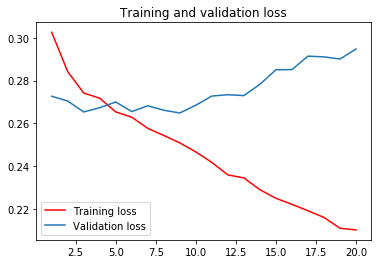

In [18]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [19]:
from keras.models import Sequential
from keras.layers import Dense, GRU
from keras.optimizers import RMSprop

In [20]:
model= Sequential()
model.add(GRU(32, input_shape=(None, float_data.shape[-1]), dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1))

In [21]:
model.compile(optimizer=RMSprop(), loss='mae')

In [22]:
history= model.fit_generator(train_gen, steps_per_epoch=500, epochs=40,
                            validation_data=val_gen, validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 166s 331ms/step - loss: 0.3392 - val_loss: 0.2761
Epoch 2/40
500/500 [==============================] - 161s 321ms/step - loss: 0.3141 - val_loss: 0.2703
Epoch 3/40
500/500 [==============================] - 162s 325ms/step - loss: 0.3078 - val_loss: 0.2702
Epoch 4/40
500/500 [==============================] - 159s 319ms/step - loss: 0.3031 - val_loss: 0.2682
Epoch 5/40
500/500 [==============================] - 160s 319ms/step - loss: 0.2994 - val_loss: 0.2683
Epoch 6/40
500/500 [==============================] - 171s 342ms/step - loss: 0.2991 - val_loss: 0.2668
Epoch 7/40
500/500 [==============================] - 159s 319ms/step - loss: 0.2952 - val_loss: 0.2658
Epoch 8/40
500/500 [==============================] - 170s 340ms/step - loss: 0.2945 - val_loss: 0.2663
Epoch 9/40
500/500 [==============================] - 160s 321ms/step - loss: 0.2911 - val_loss: 0.2647
Epoch 10/40
500/500 [==============================] - 159s 318m

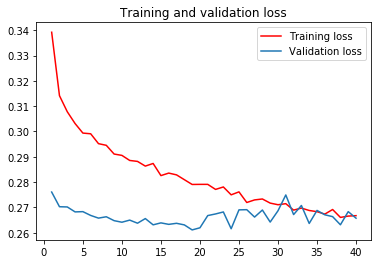

In [23]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [24]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [25]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 140s 280ms/step - loss: 0.4744 - val_loss: 0.4852
Epoch 2/20
500/500 [==============================] - 140s 279ms/step - loss: 0.4475 - val_loss: 0.4793
Epoch 3/20
500/500 [==============================] - 139s 278ms/step - loss: 0.4021 - val_loss: 0.4574
Epoch 4/20
500/500 [==============================] - 140s 279ms/step - loss: 0.3551 - val_loss: 0.4795
Epoch 5/20
500/500 [==============================] - 145s 289ms/step - loss: 0.3296 - val_loss: 0.4693
Epoch 6/20
500/500 [==============================] - 141s 282ms/step - loss: 0.3171 - val_loss: 0.4762
Epoch 7/20
500/500 [==============================] - 141s 281ms/step - loss: 0.3030 - val_loss: 0.4947
Epoch 8/20
500/500 [==============================] - 142s 284ms/step - loss: 0.2908 - val_loss: 0.4956
Epoch 9/20
500/500 [==============================] - 140s 281ms/step - loss: 0.2820 - val_loss: 0.4805
Epoch 10/20
500/500 [==============================] - 141s 282m

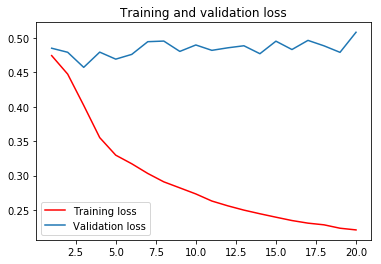

In [26]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

The reversed-order GRU strongly underperforms even the common-sense baseline, indicating that in this case, chronological processing is important to the success of our approach. This makes perfect sense: the underlying GRU layer will typically be better at remembering the recent past than the distant past, and naturally the more recent weather data points are more predictive than older data points for the problem (that’s what makes the common-sense baseline fairly strong). Thus the chronological version of the layer is bound to outperform the reversed-order version. Importantly, this isn’t true for many other problems, including natural language: intuitively, the importance of a word in understanding a sentence isn’t usually dependent on its position in the sentence. Let’s try the same trick on the LSTM IMDB example.

### Train And Evaluate An LSTM Using Reversed Sequences

In [1]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential 

Using TensorFlow backend.


In [32]:
max_features= 10000 #Number of words to consider as features
max_len=500 #Cuts off texts after this number of words (among the max_features most common words)

In [33]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

In [34]:
x_train=[x[::-1] for x in x_train] #Reverses
x_test=[x[::-1] for x in x_test]   #sequences

In [35]:
x_train= sequence.pad_sequences(x_train, maxlen=max_len) #Pad
x_test= sequence.pad_sequences(x_test, maxlen= max_len)  #sequences

In [36]:
model= Sequential()
model.add(layers.Embedding(max_features,128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

In [37]:
model.compile(optimizer='rmsprop', loss= 'binary_crossentropy', metrics=['acc'])

In [38]:
history= model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 93s 5ms/step - loss: 0.4898 - acc: 0.7665 - val_loss: 0.4662 - val_acc: 0.8170
Epoch 2/10
20000/20000 [==============================] - 92s 5ms/step - loss: 0.3063 - acc: 0.8836 - val_loss: 0.4460 - val_acc: 0.7908
Epoch 3/10
20000/20000 [==============================] - 92s 5ms/step - loss: 0.2547 - acc: 0.9050 - val_loss: 0.3460 - val_acc: 0.8536
Epoch 4/10
20000/20000 [==============================] - 93s 5ms/step - loss: 0.2213 - acc: 0.9201 - val_loss: 0.4562 - val_acc: 0.8634
Epoch 5/10
20000/20000 [==============================] - 95s 5ms/step - loss: 0.1937 - acc: 0.9311 - val_loss: 0.3420 - val_acc: 0.8766
Epoch 6/10
20000/20000 [==============================] - 93s 5ms/step - loss: 0.1716 - acc: 0.9394 - val_loss: 0.3897 - val_acc: 0.8758
Epoch 7/10
20000/20000 [==============================] - 94s 5ms/step - loss: 0.1620 - acc: 0.9461 - val_loss: 0.4216 - val_acc:

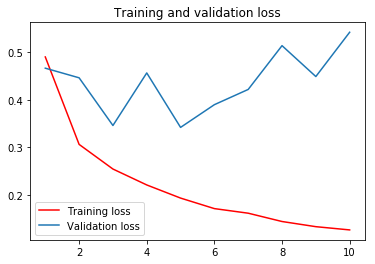

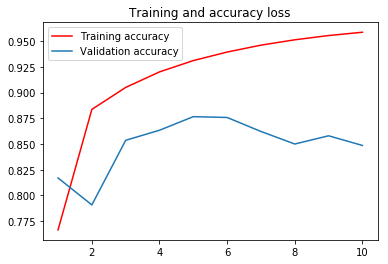

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, acc, color='red', label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and accuracy loss')
plt.legend()
plt.show()

In [40]:
model= Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

In [41]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [42]:
history= model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 183s 9ms/step - loss: 0.5303 - acc: 0.7409 - val_loss: 0.3814 - val_acc: 0.8532
Epoch 2/10
20000/20000 [==============================] - 181s 9ms/step - loss: 0.3339 - acc: 0.8699 - val_loss: 0.4444 - val_acc: 0.8406
Epoch 3/10
20000/20000 [==============================] - 190s 9ms/step - loss: 0.2670 - acc: 0.9014 - val_loss: 0.3545 - val_acc: 0.8620
Epoch 4/10
20000/20000 [==============================] - 184s 9ms/step - loss: 0.2242 - acc: 0.9185 - val_loss: 0.4568 - val_acc: 0.8318
Epoch 5/10
20000/20000 [==============================] - 180s 9ms/step - loss: 0.2008 - acc: 0.9290 - val_loss: 0.3875 - val_acc: 0.8784
Epoch 6/10
20000/20000 [==============================] - 179s 9ms/step - loss: 0.1764 - acc: 0.9376 - val_loss: 0.4405 - val_acc: 0.8632
Epoch 7/10
20000/20000 [==============================] - 179s 9ms/step - loss: 0.1654 - acc: 0.9425 - val_loss: 0.4470 - v

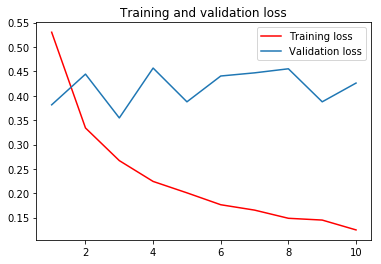

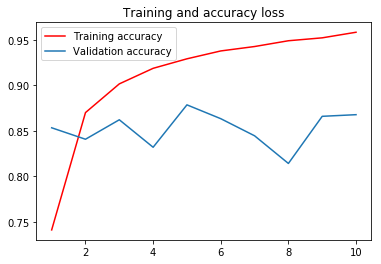

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, acc, color='red', label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and accuracy loss')
plt.legend()
plt.show()

It performs slightly better than the regular LSTM we tried in the previous section, achieving over 89% validation accuracy. It also seems to overfit more quickly, which is unsurprising because a bidirectional layer has twice as many parameters as a chronological LSTM. With some regularization, the bidirectional approach would likely be a strong performer on this task.

Now let’s try the same approach on the temperature-prediction task.

### Train A Bidirectional GRU

In [74]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [75]:
model=Sequential()
model.add(layers.Bidirectional(layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [76]:
model.compile(optimizer= RMSprop(), loss='mae')

In [79]:
history= model.fit_generator(train_gen, steps_per_epoch=500, epochs=40,
                  validation_data=val_gen, validation_steps= val_steps)

Epoch 1/40
500/500 [==============================] - 281s 562ms/step - loss: 0.2908 - val_loss: 0.2655
Epoch 2/40
500/500 [==============================] - 281s 563ms/step - loss: 0.2749 - val_loss: 0.2679
Epoch 3/40
500/500 [==============================] - 281s 562ms/step - loss: 0.2672 - val_loss: 0.2661
Epoch 4/40
500/500 [==============================] - 285s 570ms/step - loss: 0.2612 - val_loss: 0.2703
Epoch 5/40
500/500 [==============================] - 283s 566ms/step - loss: 0.2548 - val_loss: 0.2767
Epoch 6/40
500/500 [==============================] - 282s 564ms/step - loss: 0.2497 - val_loss: 0.2659
Epoch 7/40
500/500 [==============================] - 281s 562ms/step - loss: 0.2430 - val_loss: 0.2691
Epoch 8/40
500/500 [==============================] - 284s 567ms/step - loss: 0.2356 - val_loss: 0.2840
Epoch 9/40
500/500 [==============================] - 282s 564ms/step - loss: 0.2300 - val_loss: 0.2856
Epoch 10/40
500/500 [==============================] - 285s 569m